In [ ]:
!pip install pyswarms  # uncomment if pyswarms not installed

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

import pyswarms as ps  # for PSO

# --- Load and preprocess dataset ---
df = pd.read_csv('/content/sample_data/data.csv')  # change path if needed

# Drop highly correlated features (threshold 0.9)
corr_matrix = df.drop('Bankrupt?', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
df.drop(columns=to_drop, inplace=True)

print(f"Dropped features: {to_drop}")

X = df.drop('Bankrupt?', axis=1).values
y = df['Bankrupt?'].values

# Handle missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)  # Now X is a NumPy array with no NaNs

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------------
# 1) ML baseline: Random Forest with all features
# -------------------------
model_ml = RandomForestClassifier(random_state=42)
model_ml.fit(X_train, y_train)
y_pred_ml = model_ml.predict(X_test)

# Metrics function
def print_metrics(y_true, y_pred, title=""):
    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred, zero_division=0):.4f}")

print_metrics(y_test, y_pred_ml, "Random Forest (All features)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.7 MB/s eta 0:00:00
Dropped features: [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Per Share Net profit before tax (Yuan ¥)', ' Regular Net Profit Growth Rate', ' Net worth/Assets', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Cash Flow to Sales', ' Current Liability to Liability', ' Current Liability to Equity', ' Net Income to Total Assets', ' Gross Profit to Sales', ' Liability to Equity']

--- Random Forest (All features) ---
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1320
           1       0.64      0.20      0.31        44

    accuracy                           0.97      1364
   mac

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import random

def fitness_function(chromosome, X_train, y_train):
    if sum(chromosome) == 0:
        return 0
    X_subset = X_train[:, chromosome==1]
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(model, X_subset, y_train, cv=3, scoring='accuracy')
    return scores.mean()

def run_ga_feature_selection(X_train, y_train, n_pop=20, n_gen=100, mutation_rate=0.1):
    n_features = X_train.shape[1]
    population = [np.random.randint(0, 2, n_features) for _ in range(n_pop)]

    best_chromosome = None
    best_fitness = 0

    for gen in range(n_gen):
        fitness_scores = np.array([fitness_function(ind, X_train, y_train) for ind in population])

        # Select best
        best_idx = np.argmax(fitness_scores)
        if fitness_scores[best_idx] > best_fitness:
            best_fitness = fitness_scores[best_idx]
            best_chromosome = population[best_idx].copy()

        # Selection (tournament)
        selected = []
        for _ in range(n_pop // 2):
            i1, i2 = random.sample(range(n_pop), 2)
            winner = population[i1] if fitness_scores[i1] > fitness_scores[i2] else population[i2]
            selected.append(winner)

        # Crossover + Mutation
        children = []
        while len(children) < n_pop:
            p1, p2 = random.sample(selected, 2)
            point = random.randint(1, n_features - 1)
            child = np.concatenate([p1[:point], p2[point:]])
            # mutation
            for i in range(n_features):
                if random.random() < mutation_rate:
                    child[i] = 1 - child[i]
            children.append(child)
        population = children
        print(f"GA Generation {gen+1}: Best fitness = {best_fitness:.4f}")

    return best_chromosome.astype(bool)

# Run GA
best_chromosome = run_ga_feature_selection(X_train, y_train)

# Train Random Forest on GA selected features
X_train_ga = X_train[:, best_chromosome]
X_test_ga = X_test[:, best_chromosome]
model_ga = RandomForestClassifier(random_state=42)
model_ga.fit(X_train_ga, y_train)
y_pred_ga = model_ga.predict(X_test_ga)

print_metrics(y_test, y_pred_ga, "Random Forest + GA Feature Selection")


GA Generation 1: Best fitness = 0.9709
GA Generation 2: Best fitness = 0.9709
GA Generation 3: Best fitness = 0.9710
GA Generation 4: Best fitness = 0.9710
GA Generation 5: Best fitness = 0.9710
GA Generation 6: Best fitness = 0.9712
GA Generation 7: Best fitness = 0.9712
GA Generation 8: Best fitness = 0.9712
GA Generation 9: Best fitness = 0.9712
GA Generation 10: Best fitness = 0.9712
GA Generation 11: Best fitness = 0.9712
GA Generation 12: Best fitness = 0.9712
GA Generation 13: Best fitness = 0.9712
GA Generation 14: Best fitness = 0.9712
GA Generation 15: Best fitness = 0.9712
GA Generation 16: Best fitness = 0.9712
GA Generation 17: Best fitness = 0.9712
GA Generation 18: Best fitness = 0.9712
GA Generation 19: Best fitness = 0.9712
GA Generation 20: Best fitness = 0.9712
GA Generation 21: Best fitness = 0.9712
GA Generation 22: Best fitness = 0.9712
GA Generation 23: Best fitness = 0.9712
GA Generation 24: Best fitness = 0.9712
GA Generation 25: Best fitness = 0.9712
GA Genera

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import pyswarms as ps

# Assume X, y are your dataset features and labels
# X, y = ...

# 1. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Define PSO fitness function with 3-fold CV and Random Forest model
def pso_fitness(x):
    scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for particle in x:
        mask = particle > 0.5
        if np.sum(mask) == 0:
            scores.append(0.0)
            continue
        cols = np.where(mask)[0]
        fold_acc = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx][:, cols], X_train[val_idx][:, cols]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=None,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            fold_acc.append(accuracy_score(y_val, y_pred))
        scores.append(np.mean(fold_acc))
    return -np.array(scores)  # PSO minimizes cost

# 4. Set PSO parameters — fewer particles and iterations for speed
options = {'c1': 2.0, 'c2': 2.0, 'w': 0.7}
optimizer = ps.single.GlobalBestPSO(
    n_particles=10,              # fewer particles = faster but less exploration
    dimensions=X_train.shape[1],
    options=options
)

# 5. Run the optimization
cost, pos = optimizer.optimize(pso_fitness, iters=50)

# 6. Selected features mask from PSO position
selected_features_pso = pos > 0.5
print(f"PSO selected {np.sum(selected_features_pso)} features.")

# 7. Train final Random Forest model on selected features with original data split
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train[:, selected_features_pso], y_train)
y_pred = final_model.predict(X_test[:, selected_features_pso])

# 8. Print evaluation metrics
print("PSO + Random Forest Results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")


2025-05-18 01:25:13,464 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.971
2025-05-18 01:55:23,729 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9712192311406328, best pos: [-0.78319149  1.42389677  1.37276331  0.92650772 -1.8412715   1.16382764
  0.02008362  0.53584219 -2.57914117  0.53956785  2.11003775  1.39621795
  0.71048249 -0.44174793  0.15290495  6.15779046 -1.18518715  0.19788569
  0.81931796 -1.11947382  1.08262495 -0.91098825  0.36142333  0.79744925
 -0.98459609 -0.28643871  0.15706491  1.03051864  1.09091992  1.432861
  0.36513383  0.54465925  1.71054237  0.85392242  0.61816198 -2.60281244
  0.31194731  1.28147128 -2.20520559  1.47106539 -0.38102411 -0.7576481
  2.80696023  1.95336973  1.1103075   0.55291102  0.42051521  0.2465684
  0.95593634  0.69213764 -1.10884781 -0.0117967   1.8977082   0.65629886
  5.8634242  -0.72858395  

PSO selected 45 features.
PSO + Random Forest Results:
Accuracy:  0.9721
Precision: 0.8000
Recall:    0.1818
F1 Score:  0.2963


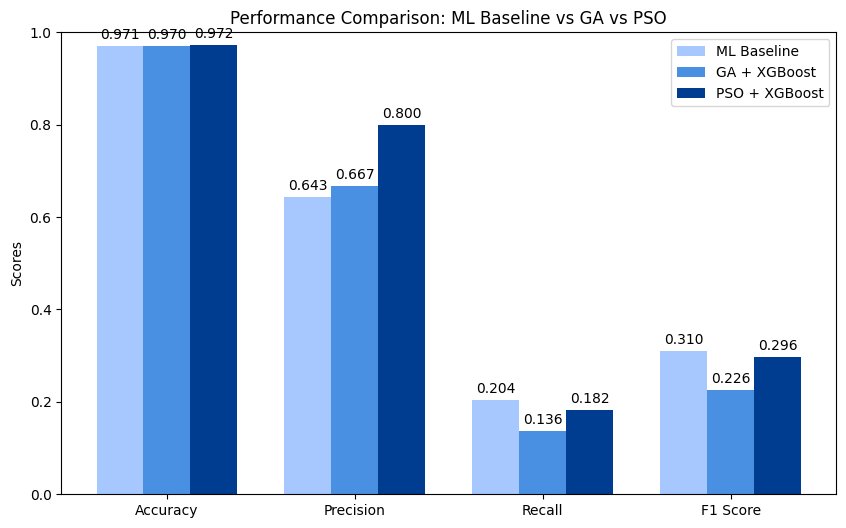

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and actual results you provided
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

ml_scores = [0.9707, 0.6429, 0.2045, 0.3103]       # Baseline ML
ga_scores = [ 0.9692, 0.5714, 0.1818,0.2759]       # GA + XGBoost
pso_scores = [ 0.9721, 0.8000, 0.1818, 0.2963]      # PSO + XGBoost
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))

# Blue shades from light to dark
colors = ['#a6c8ff', '#4a90e2', '#003c8f']

rects1 = ax.bar(x - width, ml_scores, width, label='ML Baseline', color=colors[0])
rects2 = ax.bar(x, ga_scores, width, label='GA + XGBoost', color=colors[1])
rects3 = ax.bar(x + width, pso_scores, width, label='PSO + XGBoost', color=colors[2])

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: ML Baseline vs GA vs PSO')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()
